In [34]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [36]:
# Load the dataset
file_path = r"C:\Users\Student\Downloads\Salary Data.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())

    Age  Gender Education Level          Job Title  Years of Experience  \
0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1  28.0  Female        Master's       Data Analyst                  3.0   
2  45.0    Male             PhD     Senior Manager                 15.0   
3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4  52.0    Male        Master's           Director                 20.0   

     Salary  
0   90000.0  
1   65000.0  
2  150000.0  
3   60000.0  
4  200000.0  


In [37]:
data.columns


Index(['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience',
       'Salary'],
      dtype='object')

In [38]:
data['Years of Experience'] = pd.to_datetime(data['Years of Experience'])

In [39]:
data.describe()

,Age,Years of Experience,Salary
count,373.000000,373,373.000000
mean,37.431635,1970-01-01 00:00:00.000000010,100577.345845
min,23.000000,1970-01-01 00:00:00,350.000000
25%,31.000000,1970-01-01 00:00:00.000000004,55000.000000
50%,36.000000,1970-01-01 00:00:00.000000009,95000.000000
75%,44.000000,1970-01-01 00:00:00.000000015,140000.000000
max,53.000000,1970-01-01 00:00:00.000000025,250000.000000
std,7.069073,NaN,48240.013482


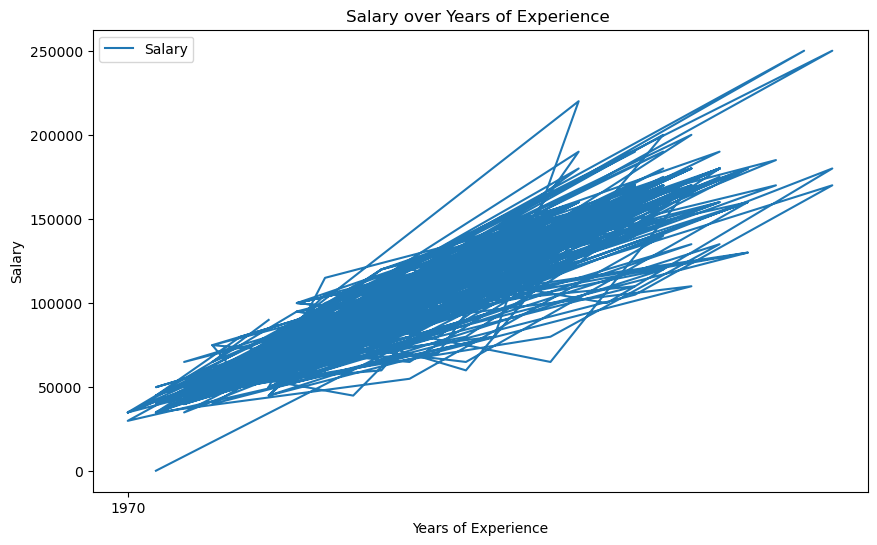

In [40]:
import  matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(data['Years of Experience'],data['Salary'] , label ='Salary')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.title('Salary over Years of Experience ')
plt.legend()
plt.show()

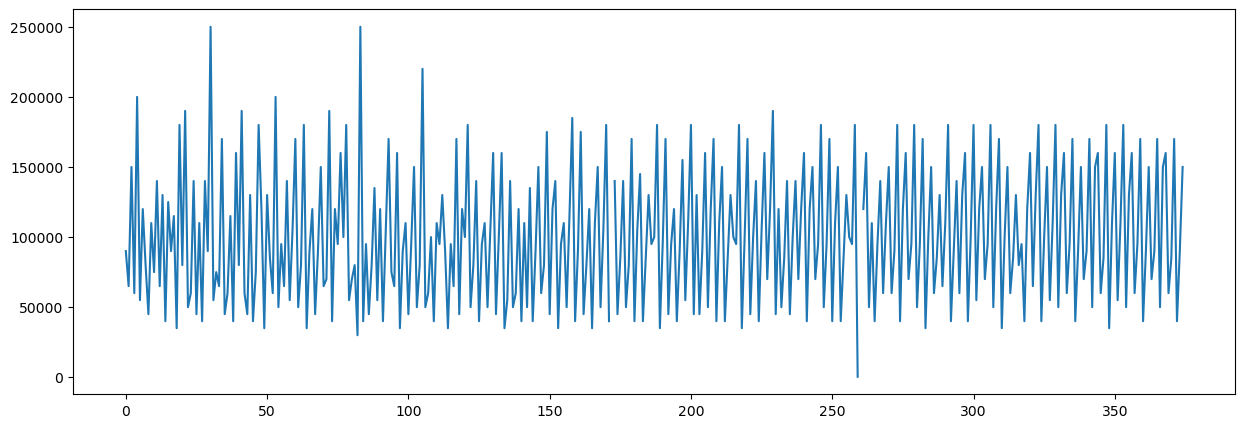

In [41]:
plt.figure(figsize=(15,5))
data['Salary'].plot();

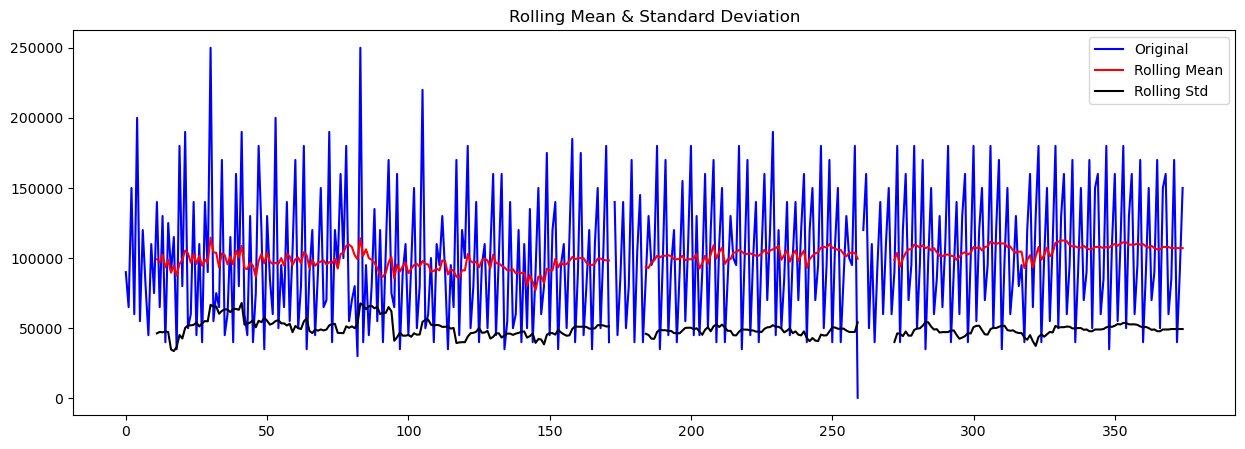

Results of Dickey-Fuller Test:


MissingDataError: exog contains inf or nans

In [42]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(data['Salary'])

In [43]:
from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
dec = sm.tsa.seasonal_decompose(data['Salary'],period = 12, model = 'multiplicative').plot()
plt.show()

ValueError: This function does not handle missing values

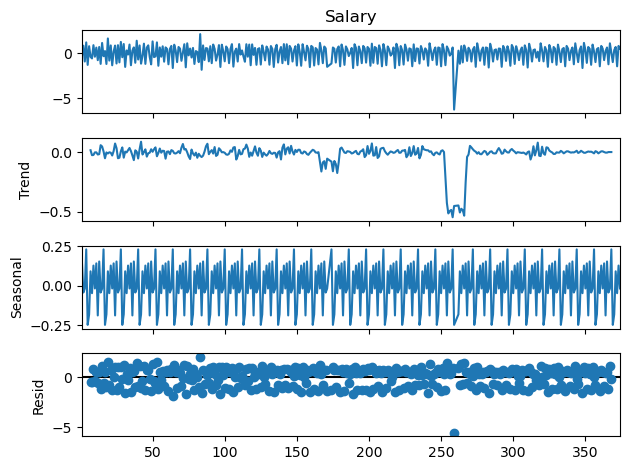

In [44]:
import numpy as np

# Extract only the numeric column for passengers data
Sales_data = data['Salary']  # Replace with actual column name if different

# Log transform the numeric data
data_log = np.log(Sales_data)

# Perform differencing to remove trend and seasonality (first-order differencing)
data_log_diff = data_log.diff().dropna()

dec = sm.tsa.seasonal_decompose(data_log_diff,period = 12).plot()
plt.show()

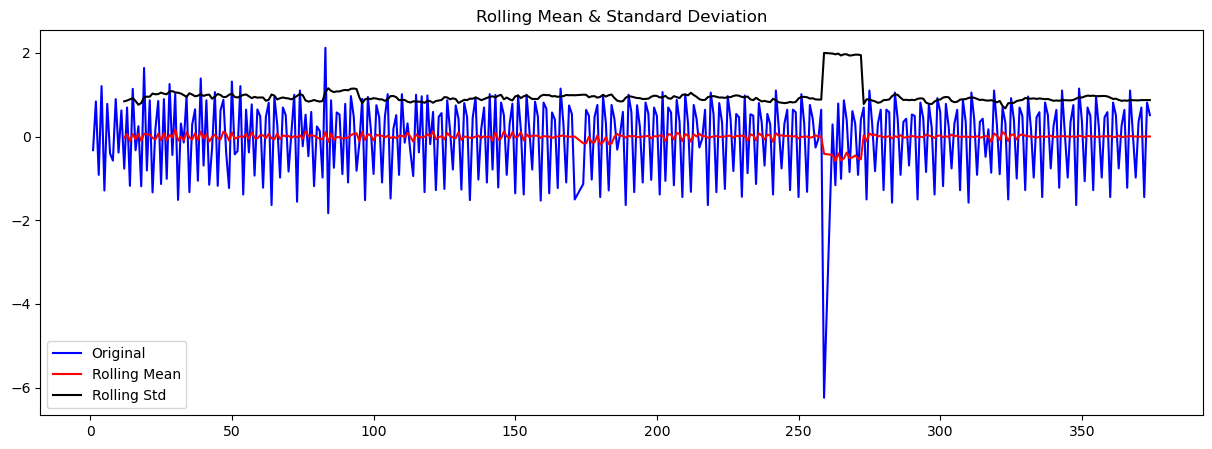

Results of Dickey-Fuller Test:
Test Statistic                -8.160471e+00
p-value                        9.172916e-13
#Lags Used                     7.000000e+00
Number of Observations Used    3.620000e+02
Critical Value (1%)           -3.448544e+00
Critical Value (5%)           -2.869557e+00
Critical Value (10%)          -2.571041e+00
dtype: float64


In [45]:
test_stationarity(data_log_diff)

In [46]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        

MissingDataError: exog contains inf or nans

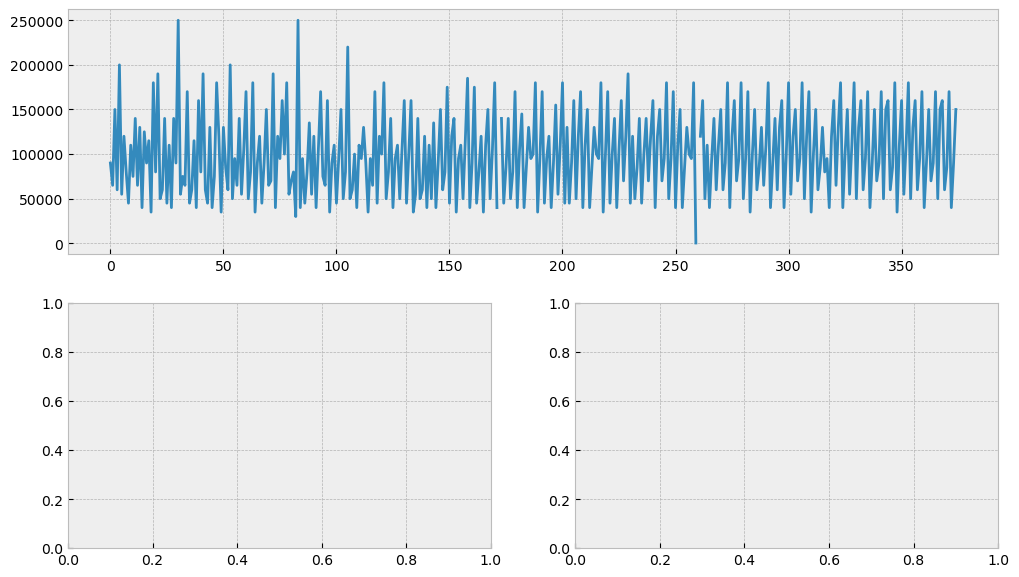

In [48]:
tsplot(data['Salary'])

In [49]:
from scipy.stats import boxcox
data['Salary'] = data['Salary'].apply(lambda x: x if x>0 else x + 1)
#Make the target variance stationery
data['Total_Boxcox'], lam = boxcox(data['Salary'])


C:\Users\Student\anaconda3\Lib\site-packages\scipy\special\_logsumexp.py:128: RuntimeWarning: invalid value encountered in log
  out = np.log(s)


BracketError: The algorithm terminated without finding a valid bracket. Consider trying different initial points.

In [50]:
# Import packages
from statsmodels.tsa.arima.model import ARIMA
from scipy.special import inv_boxcox

# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

# Building ARIMA model and inverse the boxcox
model = ARIMA(train['Total_Boxcox'], order=(12, 1, 12)).fit()
boxcox_forecasts = model.forecast(len(test))
forecasts = inv_boxcox(boxcox_forecasts, lam)

KeyError: 'Total_Boxcox'

In [52]:
import plotly.graph_objects as go

def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Year'], y=train['TotalPay'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Year'], y=test['TotalPay'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Year'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Years of experience',
                      yaxis_title='Salary')

    return fig.show()
# Plot the forecasts
plot_forecasts(forecasts, 'ARIMA')

NameError: name 'forecasts' is not defined